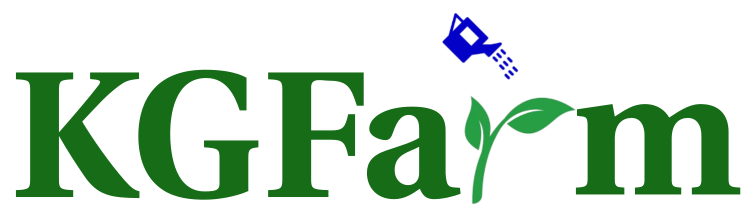
<br/>**A Feature Discovery System for Data Science Across the Enterprise**

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from operations.api import KGFarm
kgfarm = KGFarm()

In [2]:
entity_df = pd.read_csv('feature_discovery\data\earthquake\seismic_activity.csv')
X = entity_df.drop('magnitude',axis=1)
y = entity_df['magnitude']
X = X.fillna(method = 'pad')

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# instanciate the models
random_forest_regressor = RandomForestRegressor()
gradient_boosting_regressor = GradientBoostingRegressor()
support_vector_regressor = SVR()

# fit the models on data
random_forest_regressor.fit(X_train, y_train)
gradient_boosting_regressor.fit(X_train, y_train)
support_vector_regressor.fit(X_train, y_train)

# evaluate model performance
y_pred = random_forest_regressor.predict(X_test)
r2_random_forest_regressor = round(r2_score(y_test, y_pred), 3)
y_pred = gradient_boosting_regressor.predict(X_test)
r2_gradient_boosting_regressor = round(r2_score(y_test, y_pred), 3)
y_pred = support_vector_regressor.predict(X_test)
r2_support_vector_regressor= round(r2_score(y_test, y_pred), 3)

conventional_approach = {'Random forest classifier': r2_random_forest_regressor,
                         'Gradient boosting classifier': r2_gradient_boosting_regressor,
                         'Naive bayes classifier': r2_support_vector_regressor}

**Feature identification**

In [4]:
feature_info = kgfarm.identify_features(entity='earthquake', target='magnitude')
feature_info

Entity Physical_representation  \
0  earthquake_seismic_activity           earthquake_id   

                                                    Features    Feature_view  \
0  [horizontalError, gap, dmin, magError, depthError, depth]  Feature_view_2   

         Physical_table  Number_of_rows  \
0  seismic_activity.csv           26642   

                                              File_source  
0  feature_discovery\data\earthquake\seismic_activity.csv

   
**Conventional approach for building a machine learning classifier** 


In [5]:
entity_df = pd.read_csv(feature_info.iloc[0].File_source)
print(feature_info.iloc[0].Physical_table)
entity_df

seismic_activity.csv


depth    gap     dmin  earthquake_id  horizontalError  depthError  \
0       82.770  139.0   0.8700          50000             8.46      21.213   
1       79.194  104.0   1.1520          50001             5.51       7.445   
2       24.000  246.0   0.8479          50002             0.91      15.950   
3       63.787  187.0   0.4570          50003            10.25       6.579   
4       10.000  190.0   0.4000          50004             1.41       1.999   
...        ...    ...      ...            ...              ...         ...   
26637   10.000   60.0   3.9240          76637            10.07       1.765   
26638   10.000  121.0   1.8030          76638             9.17       1.870   
26639   10.000   54.0  12.7760          76639             8.02       1.792   
26640  153.264   61.0   3.7460          76640             8.52       7.433   
26641   10.000   64.0   4.1560          76641             7.85       1.876   

       magError  magnitude  
0         0.097       3.10  
1         0.083       4.50  
2         0.090       3.93  
3         0.238       4.30  
4         0.085       3.00  
...         ...        ...  
26637     0.048       5.20  
26638     0.042       5.10  
26639     0.090       5.10  
26640     0.081       4.70  
26641     0.071       5.00  

[26642 rows x 8 columns]

##  **Automating Feature discovery and transformations using KGFarm** 

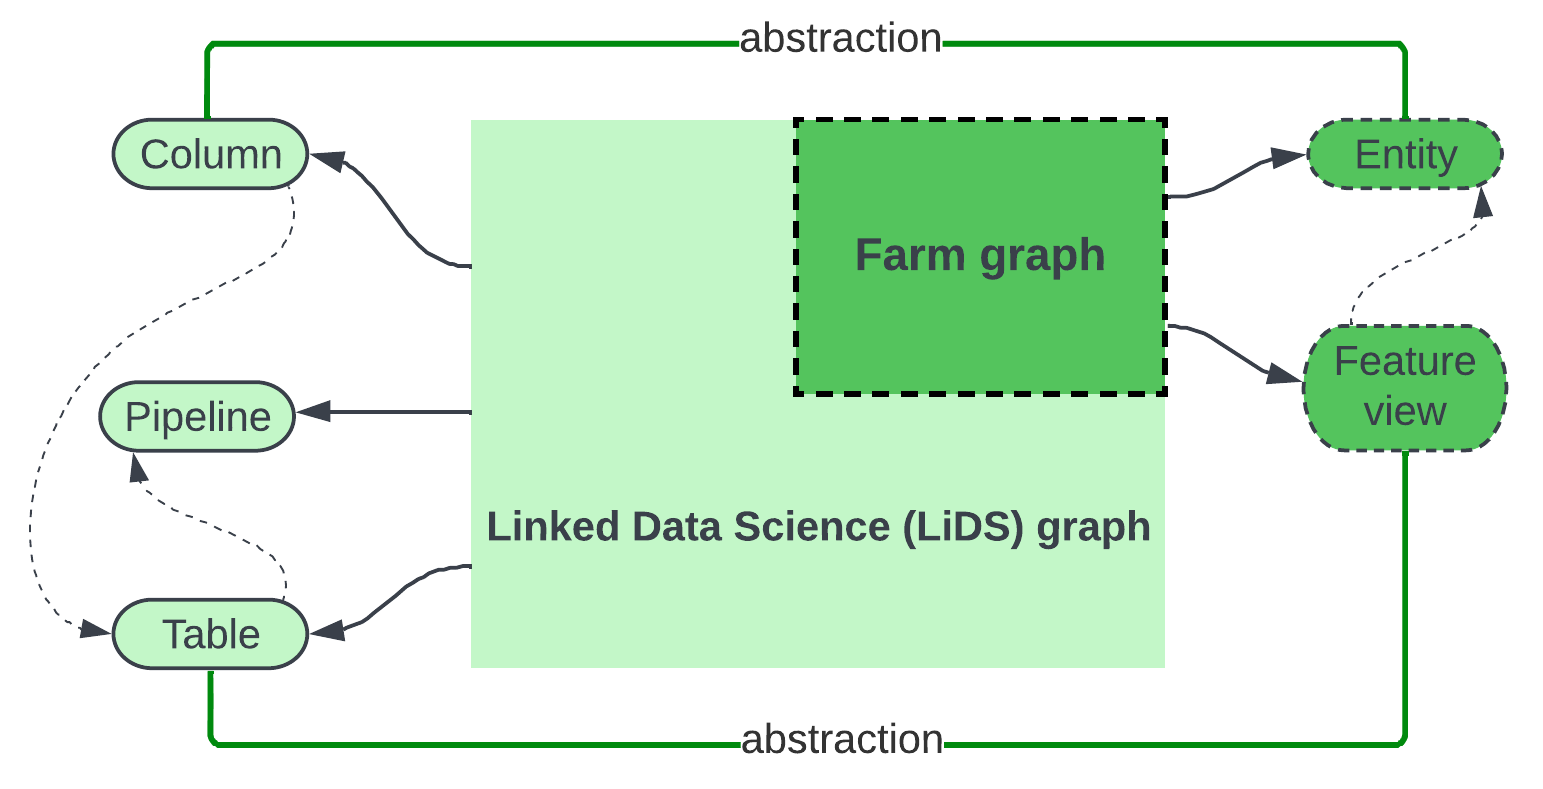

**Searching for enrichable tables**<br><br> 
<code>kgfarm.search_enrichment_options()</code> returns set of tables / <code>entity_df</code> and the corresponding Feature view that could be used in order to enrich them with fresh set of features.
  *   <b><code>Joinability_strength</code></b> represents how much a given table / <code>entity_df</code> and a Feature view are joinable. 
  * <b>    You can also pass your <code>entity_df</code> to <code>kgfarm.search_enrichment_options(entity_df: pd.Dataframe)</code> to get the corresponding Feature view that could be used for feature enrichment.</b>

In [6]:
enrichment_info = kgfarm.search_enrichment_options(entity_df)
enrichment_info

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 27.16it/s]


Enrich_with Physical_joinable_table       Join_key Joinability_strength  \
0  Feature_view_1    earthquake_stats.csv  earthquake_id                 100%   

                                              File_source Dataset_feature_view  
0  feature_discovery\data\earthquake\earthquake_stats.csv           earthquake

**Enriching data with point in time correct joins**<hr>

KGFarm can join features from a feature view to an entity dataframe in a <b>point-in-time correct way</b> i.e. KGFarm can retrieve values at a specific points in time.
KGFarm scans backward in time from the entity dataframe timestamp up to a maximum of the <code>freshness</code>  (parameter passed by user) 

 *   <code>kgfarm.enrich()</code> takes the following as input:<br>
     1. Feature view metadeta from <code>kgfarm.search_enrichment_options()</code>
     2. <code>entity_df</code> that needs to be enriched and
     3. <code>freshness</code> defines the feature freshness time-window (in days)<br>
     and returns an enriched set of features joined in point-in-time correct manner.
  

In [7]:
entity_df = kgfarm.enrich(enrichment_info.iloc[0], entity_df, freshness=10)
entity_df

Enriching entity_df with 4 feature(s) ['nst', 'magNst', 'latitude', 'longitude']


depth    gap     dmin  earthquake_id  horizontalError  depthError  \
0       82.770  139.0   0.8700          50000             8.46      21.213   
1       79.194  104.0   1.1520          50001             5.51       7.445   
2       24.000  246.0   0.8479          50002             0.91      15.950   
3       63.787  187.0   0.4570          50003            10.25       6.579   
4       10.000  190.0   0.4000          50004             1.41       1.999   
...        ...    ...      ...            ...              ...         ...   
26637   10.000   60.0   3.9240          76637            10.07       1.765   
26638   10.000  121.0   1.8030          76638             9.17       1.870   
26639   10.000   54.0  12.7760          76639             8.02       1.792   
26640  153.264   61.0   3.7460          76640             8.52       7.433   
26641   10.000   64.0   4.1560          76641             7.85       1.876   

       magError   nst  magNst  latitude  longitude  magnitude  
0         0.097  14.0    14.0   52.0999   178.5218       3.10  
1         0.083  32.0    43.0    7.1397   126.7380       4.50  
2         0.090  23.0    16.0   19.1631   -66.5251       3.93  
3         0.238  17.0     5.0   -4.7803   102.7675       4.30  
4         0.085  19.0    18.0   53.3965  -166.9417       3.00  
...         ...   ...     ...       ...        ...        ...  
26637     0.048  72.0   141.0   -6.9527   154.9829       5.20  
26638     0.042  74.0   187.0   32.3262   141.7386       5.10  
26639     0.090  60.0    40.0   -7.2411    68.0663       5.10  
26640     0.081  40.0    46.0  -19.1602   169.0428       4.70  
26641     0.071  53.0    64.0   25.1050    96.5309       5.00  

[26642 rows x 12 columns]

In [8]:
X = entity_df.drop('magnitude',axis=1)
y = entity_df['magnitude']

**Recommending data cleaning operations**

In [9]:
cleaning_info = kgfarm.recommend_cleaning_operations(X)
cleaning_info

Encoding Completed!


COMET INFO: Downloading registry model 'cleaning', version None, stage None from workspace 'nikimonjazeb'...
COMET INFO: Unzipping model to 'C:\\Users\\niki_\\OneDrive\\Documents\\GitHub\\KGFarm\\operations\\Models' ...
COMET INFO: done!


The recommended cleaning operation is:       Operation
1  Interpolate


Operation
1  Interpolate

In [11]:
X = kgfarm.apply_cleaning_operations(cleaning_info.loc[1], X)
X


all features look clean


depth    gap     dmin  earthquake_id  horizontalError  depthError  \
0       82.770  139.0   0.8700        50000.0             8.46      21.213   
1       79.194  104.0   1.1520        50001.0             5.51       7.445   
2       24.000  246.0   0.8479        50002.0             0.91      15.950   
3       63.787  187.0   0.4570        50003.0            10.25       6.579   
4       10.000  190.0   0.4000        50004.0             1.41       1.999   
...        ...    ...      ...            ...              ...         ...   
26637   10.000   60.0   3.9240        76637.0            10.07       1.765   
26638   10.000  121.0   1.8030        76638.0             9.17       1.870   
26639   10.000   54.0  12.7760        76639.0             8.02       1.792   
26640  153.264   61.0   3.7460        76640.0             8.52       7.433   
26641   10.000   64.0   4.1560        76641.0             7.85       1.876   

       magError   nst  magNst  latitude  longitude  
0         0.097  14.0    14.0   52.0999   178.5218  
1         0.083  32.0    43.0    7.1397   126.7380  
2         0.090  23.0    16.0   19.1631   -66.5251  
3         0.238  17.0     5.0   -4.7803   102.7675  
4         0.085  19.0    18.0   53.3965  -166.9417  
...         ...   ...     ...       ...        ...  
26637     0.048  72.0   141.0   -6.9527   154.9829  
26638     0.042  74.0   187.0   32.3262   141.7386  
26639     0.090  60.0    40.0   -7.2411    68.0663  
26640     0.081  40.0    46.0  -19.1602   169.0428  
26641     0.071  53.0    64.0   25.1050    96.5309  

[26642 rows x 11 columns]

**Recommending feature transformations**

In [12]:
transformation_info = kgfarm.recommend_transformation_operations(X)
transformation_info

Encoding Completed!


COMET INFO: Downloading registry model 'scaling-trans', version None, stage None from workspace 'nikimonjazeb'...
COMET INFO: Unzipping model to 'C:\\Users\\niki_\\OneDrive\\Documents\\GitHub\\KGFarm\\operations\\Models' ...
COMET INFO: done!


Encoding Completed!


COMET INFO: Downloading registry model 'unary-trans', version None, stage None from workspace 'nikimonjazeb'...
COMET INFO: Unzipping model to 'C:\\Users\\niki_\\OneDrive\\Documents\\GitHub\\KGFarm\\operations\\Models' ...
COMET INFO: done!


Recommended_transformation  \
0               RobustScaler   
1                    NoUnary   

                                                                                                      Feature  
0                                                                                                         All  
1  [depth, depthError, dmin, earthquake_id, gap, horizontalError, latitude, longitude, magError, magNst, nst]

**Transforming features on the fly**

<code>kgfarm.apply_transformations</code> applies the recommended set of transformations from <code>kgfarm.recommend_feature_transformations</code> to your <code>entity_df</code> in real-time.

   * <code>kgfarm.apply_transformations</code> expects the following as the input:<br>
     1. Transformation metadata from <code>kgfarm.recommend_feature_transformations</code> and
     2. <code>entity_df</code>


In [25]:
X = kgfarm.apply_transformation_operations(X, transformation_info.iloc[[1]])
X

depth       gap      dmin  earthquake_id  horizontalError  \
0      1.069308  0.214953 -0.285987      -1.000000         0.181970   
1      1.006387 -0.112150 -0.195371      -0.999925        -0.310518   
2      0.035226  1.214953 -0.293089      -0.999850        -1.078464   
3      0.735295  0.663551 -0.418698      -0.999775         0.480801   
4     -0.211110  0.691589 -0.437014      -0.999700        -0.994992   
...         ...       ...       ...            ...              ...   
26637 -0.211110 -0.523364  0.695367       0.999700         0.450751   
26638 -0.211110  0.046729  0.013817       0.999775         0.300501   
26639 -0.211110 -0.579439  3.539817       0.999850         0.108514   
26640  2.309679 -0.514019  0.638170       0.999925         0.191987   
26641 -0.211110 -0.485981  0.769917       1.000000         0.080134   

       depthError  magError       nst    magNst  latitude  longitude  
0        3.981332 -0.222222 -0.516129 -0.166341  0.688506   0.879815  
1        1.125493 -0.395062  0.064516  0.798436 -0.243443   0.692581  
2        2.889649 -0.308642 -0.225806 -0.099804  0.005782  -0.006195  
3        0.945862  1.518519 -0.419355 -0.465754 -0.490524   0.605912  
4       -0.004149 -0.370370 -0.354839 -0.033268  0.715382  -0.369268  
...           ...       ...       ...       ...       ...        ...  
26637   -0.052686 -0.827160  1.354839  4.058716 -0.535554   0.794706  
26638   -0.030906 -0.901235  1.419355  5.589051  0.278630   0.746819  
26639   -0.047086 -0.308642  0.967742  0.698631 -0.541532   0.480444  
26640    1.123004 -0.419753  0.322581  0.898240 -0.788595   0.845542  
26641   -0.029662 -0.543210  0.741935  1.497067  0.128947   0.583362  

[26642 rows x 11 columns]

**Re-training the classifiers with fresh and enrich set of selected features**

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# instanciate the models
random_forest_regressor = RandomForestRegressor()
gradient_boosting_regressor = GradientBoostingRegressor()
support_vector_regressor = SVR()

# fit the models on data
random_forest_regressor.fit(X_train, y_train)
gradient_boosting_regressor.fit(X_train, y_train)
support_vector_regressor.fit(X_train, y_train)

# evaluate model performance
y_pred = random_forest_regressor.predict(X_test)
r2_random_forest_regressor = round(r2_score(y_test, y_pred), 3)
y_pred = gradient_boosting_regressor.predict(X_test)
r2_gradient_boosting_regressor = round(r2_score(y_test, y_pred), 3)
y_pred = support_vector_regressor.predict(X_test)
r2_support_vector_regressor= round(r2_score(y_test, y_pred), 3)

kgfarm_approach = {'Random forest classifier': r2_random_forest_regressor,
                         'Gradient boosting classifier': r2_gradient_boosting_regressor,
                         'Naive bayes classifier': r2_support_vector_regressor}

In [15]:
kgfarm_approach

{'Random forest classifier': 0.922,
 'Gradient boosting classifier': 0.896,
 'Naive bayes classifier': 0.079}

In [16]:
conventional_approach

{'Random forest classifier': 0.86,
 'Gradient boosting classifier': 0.824,
 'Naive bayes classifier': 0.252}

In [17]:
plot_comparison(conventional_approach, kgfarm_approach)

NameError: name 'plot_comparison' is not defined

pip install coming soon!